## 🚀 Intel GPU Setup Instructions

This notebook is configured to use **Intel Iris Xe Graphics** for GPU acceleration via DirectML.

### ✅ DirectML Installation (For Intel/AMD GPUs on Windows)

DirectML has been installed in your environment. The notebook will automatically detect and use your Intel Iris Xe Graphics.

If you need to reinstall:
```bash
pip install torch-directml==0.2.5.dev240914
```

### 📋 System Requirements
- Windows 10/11
- Intel Iris Xe Graphics or AMD GPU
- PyTorch 2.0+
- DirectML backend

### 🎮 What to Expect
- **GPU Acceleration**: Your Intel Iris Xe Graphics will be used for training
- **Performance**: Faster than CPU, though not as fast as NVIDIA CUDA
- **Compatibility**: Works with integrated Intel GPUs on Windows

**Note:** After running cell 2, you should see "DirectML (Intel/AMD) available: True"

# Unified Medical X-ray Disease Detection Model
## Training a Single Model to Detect All Diseases

This notebook trains a unified deep learning model that can detect:
- **Chest conditions**: COVID-19, Pneumonia, Tuberculosis, Normal Chest
- **Bone conditions**: Osteoporosis, Normal Bone
- **Fractures**: Fractured, Non-Fractured

### Models to train:
1. ResNet50
2. DenseNet121
3. EfficientNetB0

All models will be trained on the unified dataset with 8 classes.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")

# Check for DirectML (Intel/AMD GPU support on Windows)
has_dml = False
try:
    import torch_directml
    has_dml = True
    dml_device = torch_directml.device()
except ImportError:
    pass

# Check for other GPU backends
has_xpu = hasattr(torch, 'xpu') and torch.xpu.is_available()
has_cuda = torch.cuda.is_available()

print(f"\n🎮 GPU Detection:")
print(f"  CUDA (NVIDIA) available: {has_cuda}")
print(f"  XPU (Intel Extension) available: {has_xpu}")
print(f"  DirectML (Intel/AMD) available: {has_dml}")

if has_dml:
    print(f"\n✓ DirectML backend detected (Intel/AMD GPU)")
    print(f"  This will enable GPU acceleration on your Intel Iris Xe Graphics")
elif has_xpu:
    print(f"\n✓ Intel GPU detected via XPU backend")
    print(f"  Device: {torch.xpu.get_device_name(0)}")
    print(f"  Number of XPU devices: {torch.xpu.device_count()}")
elif has_cuda:
    print(f"\n✓ NVIDIA CUDA GPU detected")
    print(f"  Device: {torch.cuda.get_device_name(0)}")
else:
    print(f"\n⚠️ No GPU acceleration detected. Will use CPU.")
    print(f"\n💡 To enable Intel Iris Xe GPU acceleration:")
    print(f"  pip install torch-directml==0.2.5.dev240914")


PyTorch version: 2.4.1+cpu

🎮 GPU Detection:
  CUDA (NVIDIA) available: False
  XPU (Intel Extension) available: False
  DirectML (Intel/AMD) available: True

✓ DirectML backend detected (Intel/AMD GPU)
  This will enable GPU acceleration on your Intel Iris Xe Graphics


In [2]:
# Configuration
DATASET_DIR = Path('unified_dataset')
MODEL_SAVE_DIR = Path('models')
MODEL_SAVE_DIR.mkdir(exist_ok=True)

# Unified class labels (8 classes)
CLASSES = [
    'COVID19',
    'PNEUMONIA',
    'TUBERCULOSIS',
    'NORMAL_CHEST',
    'OSTEOPOROSIS',
    'NORMAL_BONE',
    'FRACTURED',
    'NON_FRACTURED'
]

NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001

# Device selection - prioritize DirectML > Intel XPU > CUDA > CPU
if has_dml:
    DEVICE = dml_device  # DirectML device for Intel/AMD GPU
    DEVICE_TYPE = 'directml'
    print(f"✓ Using DirectML device (Intel Iris Xe Graphics)")
elif has_xpu:
    DEVICE = torch.device('xpu:0')  # Intel GPU via XPU
    DEVICE_TYPE = 'xpu'
    print(f"✓ Using Intel GPU (XPU): {torch.xpu.get_device_name(0)}")
elif has_cuda:
    DEVICE = torch.device('cuda:0')  # NVIDIA GPU
    DEVICE_TYPE = 'cuda'
    print(f"✓ Using NVIDIA GPU (CUDA): {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')  # Fallback to CPU
    DEVICE_TYPE = 'cpu'
    print(f"⚠️ Using CPU (no GPU acceleration)")

print(f"\nConfiguration:")
print(f"  Device: {DEVICE}")
print(f"  Device type: {DEVICE_TYPE}")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"\nClasses: {CLASSES}")


✓ Using DirectML device (Intel Iris Xe Graphics)

Configuration:
  Device: privateuseone:0
  Device type: directml
  Number of classes: 8
  Image size: 224x224
  Batch size: 32
  Number of epochs: 50
  Learning rate: 0.0001

Classes: ['COVID19', 'PNEUMONIA', 'TUBERCULOSIS', 'NORMAL_CHEST', 'OSTEOPOROSIS', 'NORMAL_BONE', 'FRACTURED', 'NON_FRACTURED']


In [3]:
# Load dataset info
info_file = DATASET_DIR / 'dataset_info.json'
if info_file.exists():
    with open(info_file, 'r') as f:
        dataset_info = json.load(f)
    
    print("\n📊 Dataset Statistics:")
    print("=" * 60)
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()} Set:")
        for cls, count in dataset_info['splits'][split].items():
            if cls != 'total':
                print(f"  {cls:20s}: {count:6d} images")
        print(f"  {'TOTAL':20s}: {dataset_info['splits'][split]['total']:6d} images")
    print("=" * 60)
else:
    print("⚠️ Dataset info not found. Please run prepare_unified_dataset.py first!")


📊 Dataset Statistics:

TRAIN Set:
  COVID19             :   5062 images
  PNEUMONIA           :   5424 images
  TUBERCULOSIS        :   4900 images
  NORMAL_CHEST        :   4900 images
  OSTEOPOROSIS        :    520 images
  NORMAL_BONE         :    520 images
  FRACTURED           :   9212 images
  NON_FRACTURED       :   9280 images
  TOTAL               :  39818 images

VAL Set:
  COVID19             :   1084 images
  PNEUMONIA           :   1162 images
  TUBERCULOSIS        :   1050 images
  NORMAL_CHEST        :   1050 images
  OSTEOPOROSIS        :    112 images
  NORMAL_BONE         :    112 images
  FRACTURED           :    674 images
  NON_FRACTURED       :    984 images
  TOTAL               :   6228 images

TEST Set:
  COVID19             :   1086 images
  PNEUMONIA           :   1164 images
  TUBERCULOSIS        :   1050 images
  NORMAL_CHEST        :   1050 images
  OSTEOPOROSIS        :    112 images
  NORMAL_BONE         :    112 images
  FRACTURED           :    476 i

In [4]:
# Custom Dataset Class
class UnifiedXRayDataset(Dataset):
    """Unified X-ray dataset for all disease types."""
    
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir: Path to dataset directory (train/val/test)
            transform: Optional transform to be applied on images
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.classes = CLASSES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load all image paths and labels
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if class_dir.exists():
                class_idx = self.class_to_idx[class_name]
                for img_path in class_dir.glob('*.*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(img_path)
                        self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Data Augmentation and Preprocessing
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = UnifiedXRayDataset(DATASET_DIR / 'train', transform=train_transform)
val_dataset = UnifiedXRayDataset(DATASET_DIR / 'val', transform=val_test_transform)
test_dataset = UnifiedXRayDataset(DATASET_DIR / 'test', transform=val_test_transform)

# Create data loaders
# Note: pin_memory only works with CUDA, disable for DirectML and other backends
use_pin_memory = (DEVICE_TYPE == 'cuda')

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,  # Set to 0 for notebook compatibility
    pin_memory=use_pin_memory
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=use_pin_memory
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=use_pin_memory
)

print(f"\n📦 Dataset Sizes:")
print(f"  Training: {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Test: {len(test_dataset)} images")
print(f"\n  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Pin memory: {use_pin_memory}")
print(f"\n💡 Note: DirectML GPU acceleration is enabled for training!")



📦 Dataset Sizes:
  Training: 39806 images
  Validation: 6216 images
  Test: 5574 images

  Batch size: 32
  Training batches: 1244
  Validation batches: 195
  Test batches: 175
  Pin memory: False

💡 Note: DirectML GPU acceleration is enabled for training!


Sample Training Images:


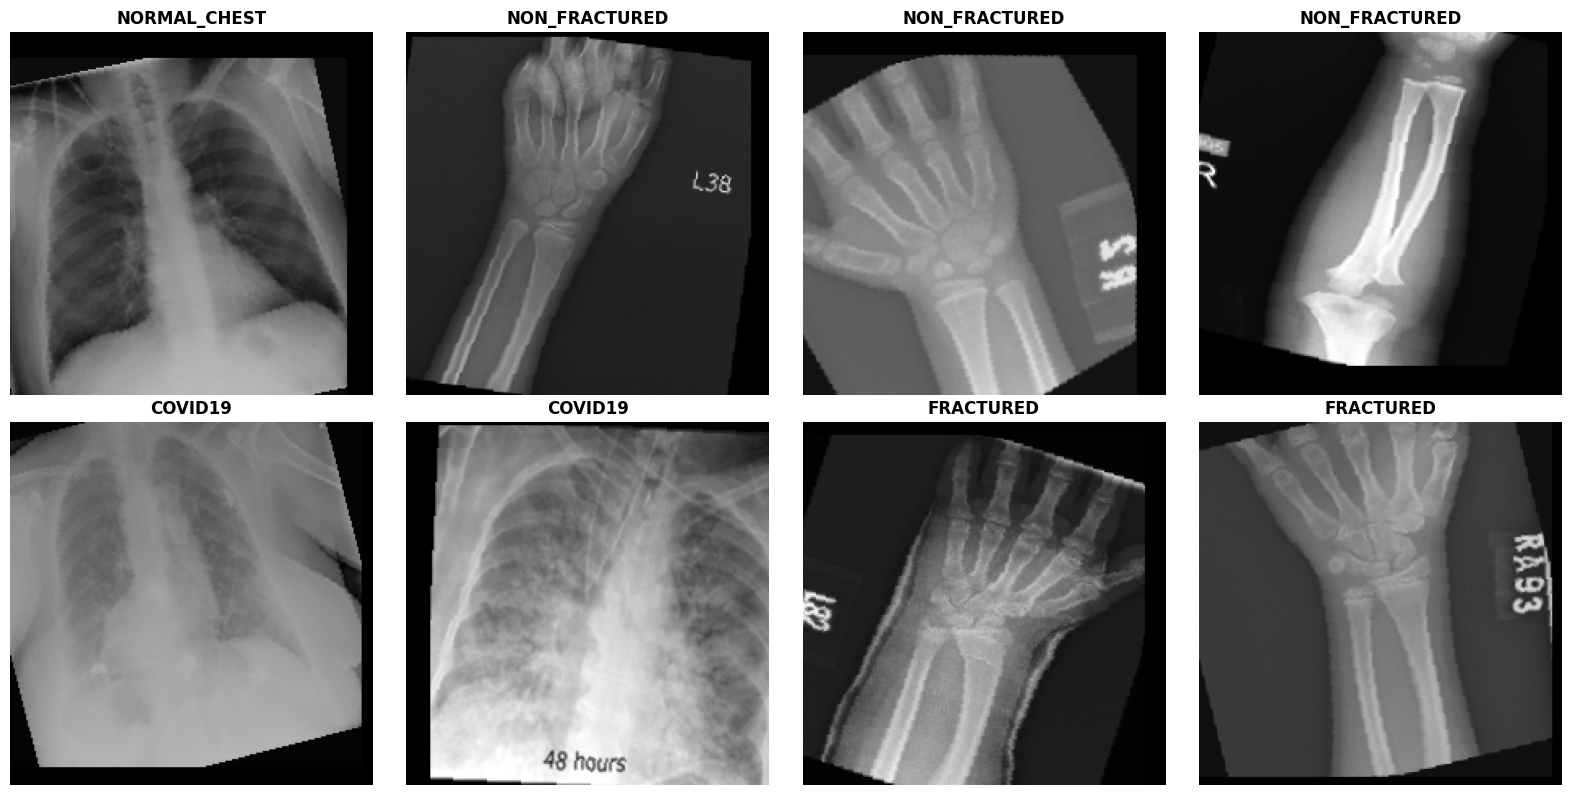

In [6]:
# Visualize sample images
def show_sample_images(dataset, num_samples=8):
    """Display sample images from dataset."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx, ax in zip(indices, axes):
        img, label = dataset[idx]
        
        # Denormalize image for display
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"{CLASSES[label]}", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample Training Images:")
show_sample_images(train_dataset)

In [7]:
# Model Architecture Classes

class UnifiedResNet50(nn.Module):
    """ResNet50 for unified disease classification."""
    
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super(UnifiedResNet50, self).__init__()
        self.backbone = models.resnet50(weights='DEFAULT' if pretrained else None)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False
        
        # Replace final layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


class UnifiedDenseNet121(nn.Module):
    """DenseNet121 for unified disease classification."""
    
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super(UnifiedDenseNet121, self).__init__()
        self.backbone = models.densenet121(weights='DEFAULT' if pretrained else None)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False
        
        # Replace final layer
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.classifier.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


class UnifiedEfficientNetB0(nn.Module):
    """EfficientNetB0 for unified disease classification."""
    
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super(UnifiedEfficientNetB0, self).__init__()
        self.backbone = models.efficientnet_b0(weights='DEFAULT' if pretrained else None)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False
        
        # Replace final layer
        self.backbone.classifier[1] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

print("✓ Model architectures defined")

✓ Model architectures defined


In [8]:
# Training and Evaluation Functions

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def train_model(model, model_name, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """Complete training loop with DirectML support."""
    print(f"\n{'='*70}")
    print(f"Training {model_name}")
    print(f"Device: {DEVICE} ({DEVICE_TYPE})")
    print(f"{'='*70}\n")
    
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = MODEL_SAVE_DIR / f'unified_{model_name}.pth'
            torch.save(model.state_dict(), save_path)
            print(f"✓ Saved best model to {save_path} (Val Acc: {val_acc:.2f}%)")
        
        # Clear cache for GPU memory management
        # Note: DirectML doesn't have explicit cache clearing, but we can use garbage collection
        if epoch % 5 == 0 and DEVICE_TYPE == 'cuda':
            torch.cuda.empty_cache()
    
    print(f"\n{'='*70}")
    print(f"Training Complete! Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"{'='*70}\n")
    
    return model, history

print("✓ Training functions defined")
print(f"✓ Using device: {DEVICE_TYPE}")


✓ Training functions defined
✓ Using device: directml


## Train ResNet50

In [9]:
# Train ResNet50
resnet_model = UnifiedResNet50(num_classes=NUM_CLASSES, pretrained=True)
resnet_model, resnet_history = train_model(resnet_model, 'ResNet50', train_loader, val_loader)


Training ResNet50
Device: privateuseone:0 (directml)


Epoch 1/50
--------------------------------------------------


Training:   0%|          | 0/1244 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Train DenseNet121

In [ ]:
# Train DenseNet121
densenet_model = UnifiedDenseNet121(num_classes=NUM_CLASSES, pretrained=True)
densenet_model, densenet_history = train_model(densenet_model, 'DenseNet121', train_loader, val_loader)

## Train EfficientNetB0

In [ ]:
# Train EfficientNetB0
efficientnet_model = UnifiedEfficientNetB0(num_classes=NUM_CLASSES, pretrained=True)
efficientnet_model, efficientnet_history = train_model(efficientnet_model, 'EfficientNetB0', train_loader, val_loader)

In [ ]:
# Plot training history
def plot_training_history(histories, model_names):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    for history, name in zip(histories, model_names):
        axes[0].plot(history['train_loss'], label=f'{name} Train', linestyle='--')
        axes[0].plot(history['val_loss'], label=f'{name} Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    for history, name in zip(histories, model_names):
        axes[1].plot(history['train_acc'], label=f'{name} Train', linestyle='--')
        axes[1].plot(history['val_acc'], label=f'{name} Val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(
    [resnet_history, densenet_history, efficientnet_history],
    ['ResNet50', 'DenseNet121', 'EfficientNetB0']
)

In [ ]:
# Evaluation on Test Set
def evaluate_model(model, model_name, test_loader, device):
    """Evaluate model on test set."""
    print(f"\n{'='*70}")
    print(f"Evaluating {model_name} on Test Set")
    print(f"{'='*70}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%\n")
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, all_preds, all_labels

In [ ]:
# Evaluate all models
resnet_acc, _, _ = evaluate_model(resnet_model, 'ResNet50', test_loader, DEVICE)
densenet_acc, _, _ = evaluate_model(densenet_model, 'DenseNet121', test_loader, DEVICE)
efficientnet_acc, _, _ = evaluate_model(efficientnet_model, 'EfficientNetB0', test_loader, DEVICE)

In [ ]:
# Summary of Results
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"\nTest Set Accuracies:")
print(f"  ResNet50:        {resnet_acc * 100:.2f}%")
print(f"  DenseNet121:     {densenet_acc * 100:.2f}%")
print(f"  EfficientNetB0:  {efficientnet_acc * 100:.2f}%")
print("\n" + "="*70)

# Save model info
model_info = {
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'models': {
        'ResNet50': {
            'path': 'models/unified_ResNet50.pth',
            'test_accuracy': float(resnet_acc)
        },
        'DenseNet121': {
            'path': 'models/unified_DenseNet121.pth',
            'test_accuracy': float(densenet_acc)
        },
        'EfficientNetB0': {
            'path': 'models/unified_EfficientNetB0.pth',
            'test_accuracy': float(efficientnet_acc)
        }
    }
}

with open('unified_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("\n✓ Model information saved to 'unified_model_info.json'")
print("\n✅ Training Complete! You can now use these models in your application.")